In [1]:
cd '/home/dpirvu/DarkPhoton/'

/home/dpirvu/DarkPhoton
The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import os,sys

print(sys.path)

sys.path.remove('/home/dpirvu/DarkPhotonxunWISE/hmvec-master')

sys.path.append('/home/dpirvu/DarkPhoton/hmvec-master/')
sys.path.append('/home/dpirvu/python_stuff/')

print(sys.path)

import hmvec as hm

from plotting import *
from compute_power_spectra import *
#from params import *
from params_old import *

%matplotlib inline

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


['/home/dpirvu/DarkPhoton', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/home/dpirvu/DarkPhotonxunWISE/hmvec-master', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython']
['/home/dpirvu/DarkPhoton', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/DarkPhoton/hmvec-master/', '/home/dpirvu/python_stuff/']


In [3]:
from scipy.ndimage import gaussian_filter1d

In [4]:
def beautify(ax, loc='best', ncol=1, ttl=None, bb=None):
    try:
        len(ax)
    except:
        ax = np.array([ax])
    for ai, aa in enumerate(ax.flatten()):
        aa.grid(which='both', ls=':', color='lightgray', alpha=0.7)
        aa.tick_params(direction='in', which='both', top=True, right=True)
        #aa.ticklabel_format(axis='both', style='scientific', scilimits=[0.,0.])
        aa.xaxis.set_label_coords(0.5, -0.15)
        aa.yaxis.set_label_coords(-0.15, 0.5)
        aa.xaxis.label.set_color('k')
        aa.yaxis.label.set_color('k')
        aa.tick_params(axis='x', colors='k')
        aa.tick_params(axis='y', colors='k')
        aa.tick_params(direction='in', which='both', bottom=None, left=None, top=None, right=None)
        aa.spines['left'].set_color('k')
        aa.spines['right'].set_color('k')
        aa.spines['top'].set_color('k')
        aa.spines['bottom'].set_color('k')
        aa.legend(title=ttl, loc=loc, ncol=ncol, bbox_to_anchor=bb, frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=0.)
    return ax

# Define function for string formatting of scientific notation
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10.**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\times 10^{{{1:d}}}$".format(coeff, exponent, precision)
 #   return r"$10^{{{1:d}}}$".format(coeff, exponent, precision)

def clear_last_coln(ax, title=None):
    ax[len(ax)-1].legend(loc='center', ncol=1, frameon=False, title=title)
    ax[len(ax)-1].set_ylim((-1,0))
    ax[len(ax)-1].set_xlim((-1,0))
    ax[len(ax)-1].spines['right'].set_visible(False)
    ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False)
    ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([])
    ax[len(ax)-1].axes.xaxis.set_ticklabels([])
    ax[len(ax)-1].grid(False)
    ax[len(ax)-1].tick_params(left = False,top = False,right = False,bottom = False)
    return ax


In [5]:
ellMax = 9600
ells = np.arange(ellMax)

getgas = True
dictKey = dictKey_gas
model = modelParams_gas
rscale = False

allcols = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
cych = cycle(allcols)

cych = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

baseline = 30
units = xov(baseline)/ghztoev(baseline)

ztype = [2., 6., 10.]
zreio = 6.
nZs = 50

compute_noise = True
compute_BB_noise = True

fsky = [0.7, 0.5, 0.5]


In [6]:
avtaulist = np.zeros((len(ztype), len(dictKey))) 
tauMWlist = np.zeros(len(dictKey))
dtaudzlist, zsList = np.zeros((2, len(ztype), len(dictKey), 50))
Cell1Hdata, Cell2Hdata, CellTauTau = np.zeros((3, len(ztype), len(dictKey), ellMax))
Screening = np.zeros((len(ztype), len(dictKey), 4, ellMax))
Survey = np.zeros((len(dictKey), ellMax))
rcrossdata = np.zeros((len(ztype), len(dictKey), 50, 100))

for mind, MA in enumerate(dictKey):
    for zind, ztest in enumerate(ztype):

        zMin, zMax, rMin, rMax = chooseModel(MA, model)
        zMax = min(ztest, zMax)

        data = import_data(MA, nZs, zMin, zMax, ellMax, getgas, rscale)
        rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H, CMBDP, CMBDP2 = data

        rcrossdata[zind, mind] = rcross

        avtaulist[zind, mind]  = 4.*np.pi * avtau * units
        dtaudzlist[zind, mind] = 4.*np.pi * dtaudz * units
        tauMWlist[mind]        = probMW * units
        zsList[zind, mind]     = np.linspace(zMin,zMax,nZs)

        Cell1Hdata[zind, mind] = Cell1H
        Cell2Hdata[zind, mind] = Cell2H

        CellTauTau[zind, mind] = (avtaulist[zind, mind]/(4*np.pi))**2. * (Cell1H + Cell2H)
        Screening[zind, mind]  = (avtaulist[zind, mind]/(4*np.pi))**2. * CMBDP

for mind, MA in enumerate(dictKey):
    Survey[mind] = (avtaulist[1, mind]/(4*np.pi))**2. * (Cell1Hdata[0, mind] + Cell2Hdata[0, mind])


In [7]:
if True:
    ms  = np.geomspace(1e11,1e17,100)       # masses
    zs  = np.linspace(zMin,zMax,nZs)        # redshifts
    ks  = np.geomspace(1e-4,1e3,1001)       # wavenumbers

    # Halo Model
    hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')
    #gas = hcos.add_battaglia_profile("y", family="AGN", xmax=2, nxs=30000)

    chis   = hcos.comoving_radial_distance(zs)
    rvirs  = np.asarray([hcos.rvir(ms,zz) for zz in zs])
    cs     = hcos.concentration()
    Hz     = hcos.h_of_z(zs)
    nzm    = hcos.get_nzm()
    biases = hcos.get_bh()
    deltav = hcos.deltav(zs)
    rhocritz = hcos.rho_critical_z(zs)
    dvols = get_volume_conv(chis, Hz)


In [8]:
print('Importing base CMB PS and adding T monopole.')
CMB_ps        = hcos.CMB_power_spectra()
unlenCMB      = CMB_ps['unlensed_scalar']
unlenCMB      = unlenCMB[:ellMax, :]
unlenCMB[0,0] = TCMB**2.
lensedCMB     = CMB_ps['lensed_scalar']
lensedCMB     = lensedCMB[:ellMax, :]
lensedCMB[0,0]= TCMB**2.


Importing base CMB PS and adding T monopole.


In [14]:
sigmaEpsilonList = np.ones((len(dictKey[dictKey<=1e-11])+2, 3, 2)) # (#masses sampled, #experiments sampled, #forecast methods)

for mind, MA in enumerate(dictKey[dictKey<=1e-11]):
    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        if expname=='Planck':
            mm = 2
            mmm = 5000
        else:
            mm = 2
            mmm = 9000

        ellss = np.arange(mmm)            
        ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))

        zind = 1

        leftover = ILCnoise[mind, :, ellss]
        screening = Screening[zind, mind, :, ellss]
        screening[np.isnan(screening)] = 0.
        template = Survey[mind, ellss]

        # first constraint: CMB screening
        sigmaEpsilonList[mind+1, eind, 0] = fsky[eind]**(-0.125) * sigma_screening(0., mm, mmm, screening, leftover)
        # second constraint: CMB screening cross correlated wih template
        sigmaEpsilonList[mind+1, eind, 1] = fsky[eind]**(-0.25) * sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening, leftover, template)
        # third + fourth constraint: bispectrum
     #   sigmaEpsilonList[mind+1, eind, 2] = fsky[eind]**(-0.25) * bispTTT[mind, eind]
     #   sigmaEpsilonList[mind+1, eind, 3] = fsky[eind]**(-0.25) * bispTEB[mind, eind]

    sigmaEpsilonList[ :2, :, :] = 1e-3
    sigmaEpsilonList[-1, :, :] = 1e-3

print('Done')

/home/dpirvu/DarkPhoton/hmvec-master/compute_power_spectra.py:533: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.21 * (np.sum(TrF[ellmin:])**(-0.25))**0.5


Done


In [15]:
def add_existing_constraints(ax):
    jhdata = np.genfromtxt('./data/DPlimits.txt')
    cych = cycle(allcols)

    plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=1)

    xvals, firasz6 = np.load('./data/gas_contour.npy')
  #  plt.fill_between(xvals, firasz6, np.ones(len(firasz6)), color=allcols[0])
 #   plt.text(1.8e-12, 5e-6, r'$\rm FIRAS$', color='white', weight="bold", rotation=40)

    plt.xlim((1e-14, 1e-10))
    plt.ylim((10e-11, 5e-5))
    #plt.ylabel(r'${\rm Coupling \; Constant \;} \varepsilon$')
    #plt.xlabel(r'${\rm Dark \; Photon \; Mass \;} m_{\rm A^{\prime}} \; [{\rm eV}]$')
    plt.ylabel(r'$\varepsilon$')
    plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
    plt.xscale('log')
    plt.yscale('log')
    return ax
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(44, 3, 2)


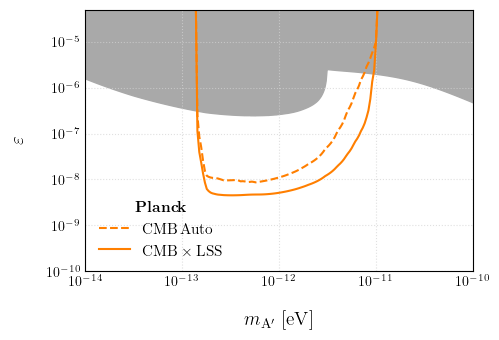

In [19]:
constraint = [r'$\rm CMB \, Auto$', \
              r'${\rm CMB} \times {\rm LSS}$', \
           #   r'${\rm Reconstruction} \times {\rm LSS}$', \
              r'$\left< T^{\rm dSc} \times T^{\rm Sc} \times T^{\rm Sc} \right>$',\
              r'$\left< T^{\rm dSc} \times E^{\rm Sc} \times B^{\rm Sc} \right>$']

fig, ax = plt.subplots(1,1, figsize = (5,3.4))
lssss = ['--', '-', ':', '-.', ':']

masslist_old = [1.19e-13]+dictKey[dictKey<=1e-11].tolist()+[1.1e-11]
masslist = [1.19e-13]+np.geomspace(dictKey[dictKey<=1e-11][0], dictKey[dictKey<=1e-11][-1], 100).tolist()+[1.1e-11]

datashape = np.shape(sigmaEpsilonList); print(datashape)
for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    secondary_lines, secondary_labels = [], []
    if eind==1: break

    for method in range(datashape[-1]):
        if eind==1 and method>1: continue
        if eind==2 and method<=1: continue

        col = [allcols[1], allcols[2], allcols[5]][eind]
        lss = lssss[method]

        if method>=2:
            list2intp0 = gaussian_filter1d(sigmaEpsilonList[:3, eind, method], 0.4, mode='nearest')
            sigmaEpsilonList[6, eind, method] = 2*sigmaEpsilonList[7, eind, method]
            sigmaEpsilonList[8, eind, method] = 0.5*(sigmaEpsilonList[7, eind, method] + sigmaEpsilonList[9, eind, method])
            sigmaEpsilonList[12, eind, method] = 0.5*(sigmaEpsilonList[11, eind, method] + sigmaEpsilonList[13, eind, method])
            sigmaEpsilonList[18, eind, method] = 0.5*(sigmaEpsilonList[17, eind, method] + sigmaEpsilonList[19, eind, method])
            list2intp1 = gaussian_filter1d(sigmaEpsilonList[3:30, eind, method], 0.8, mode='nearest')
            list2intp2 = gaussian_filter1d(sigmaEpsilonList[30:-1, eind, method], 0.01, mode='nearest')
            list2intp3 = gaussian_filter1d(sigmaEpsilonList[-1:, eind, method], 0.5, mode='nearest')
            list2intp = list2intp0.tolist() + list2intp1.tolist() + list2intp2.tolist() + list2intp3.tolist()
        else:
            list2intp0 = gaussian_filter1d(sigmaEpsilonList[:3, eind, method], 0.5, mode='nearest')
            list2intp = list2intp0.tolist() + sigmaEpsilonList[3:, eind, method].tolist()
            
        ff = interpolate.interp1d(masslist_old, 1./np.asarray(list2intp), kind='linear')
        list2plot1 = 1./ff(masslist)

       # l1, = plt.plot(masslist_old, sigmaEpsilonList[:, eind, method], color=col, ls=lss)
        l1, = plt.plot(masslist, list2plot1, color=col, ls=lss)
        secondary_labels.append(constraint[method])
        secondary_lines.append(l1)

    ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname, \
                             fancybox=True, framealpha=1, frameon=False, loc=3))
#                             bbox_to_anchor=[(1.,0.8), (1.,0.5), (1.5,0.27)][eind]))

   # ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname, \
   #                          fancybox=True, framealpha=0.9, borderpad=0.25, loc=['center left',3,2][eind]))
add_existing_constraints(ax)
beautify(ax)
plt.grid(False, which='minor')
plt.savefig('./plots/gas_contours_Planck.pdf')
plt.show()

(44, 3, 2)


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


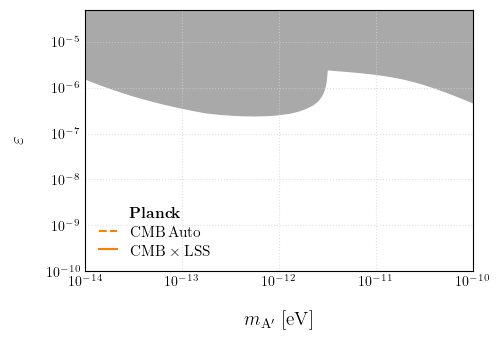

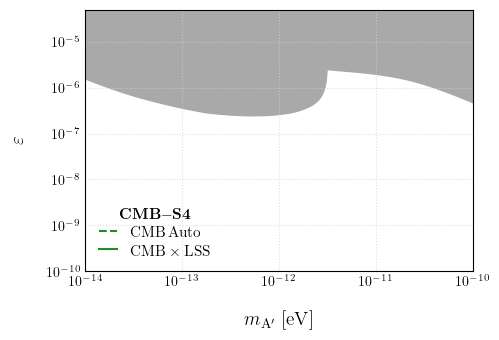

In [12]:
constraint = [r'$\rm CMB \, Auto$', \
              r'${\rm CMB} \times {\rm LSS}$', \
           #   r'${\rm Reconstruction} \times {\rm LSS}$', \
              r'$\left< T^{\rm dSc} \times T^{\rm Sc} \times T^{\rm Sc} \right>$',\
              r'$\left< T^{\rm dSc} \times E^{\rm Sc} \times B^{\rm Sc} \right>$']


masslist_old = [1.19e-13]+dictKey[dictKey<=1e-11].tolist()+[1.1e-11]
masslist = [1.19e-13]+np.geomspace(dictKey[dictKey<=1e-11][0], dictKey[dictKey<=1e-11][-1], 100).tolist()+[1.1e-11]

datashape = np.shape(sigmaEpsilonList); print(datashape)
for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    if eind==2: continue

    fig, ax = plt.subplots(1,1, figsize = (5,3.4))
    lssss = ['--', '-', ':', '-.', ':']

    for method in range(datashape[-1]):
        if eind==1 and method>1: continue
        if eind==2 and method<=1: continue

        col = [allcols[1], allcols[2], allcols[5]][eind]
        lss = lssss[method]

        if method>=2:
            list2intp0 = gaussian_filter1d(sigmaEpsilonList[:3, eind, method], 0.4, mode='nearest')
            sigmaEpsilonList[6, eind, method] = 2*sigmaEpsilonList[7, eind, method]
            sigmaEpsilonList[8, eind, method] = 0.5*(sigmaEpsilonList[7, eind, method] + sigmaEpsilonList[9, eind, method])
            sigmaEpsilonList[12, eind, method] = 0.5*(sigmaEpsilonList[11, eind, method] + sigmaEpsilonList[13, eind, method])
            sigmaEpsilonList[18, eind, method] = 0.5*(sigmaEpsilonList[17, eind, method] + sigmaEpsilonList[19, eind, method])
            list2intp1 = gaussian_filter1d(sigmaEpsilonList[3:30, eind, method], 0.8, mode='nearest')
            list2intp2 = gaussian_filter1d(sigmaEpsilonList[30:-1, eind, method], 0.01, mode='nearest')
            list2intp3 = gaussian_filter1d(sigmaEpsilonList[-1:, eind, method], 0.5, mode='nearest')
            list2intp = list2intp0.tolist() + list2intp1.tolist() + list2intp2.tolist() + list2intp3.tolist()
        else:
            list2intp0 = gaussian_filter1d(sigmaEpsilonList[:3, eind, method], 0.5, mode='nearest')
            list2intp = list2intp0.tolist() + sigmaEpsilonList[3:, eind, method].tolist()
            
        ff = interpolate.interp1d(masslist_old, 1./np.asarray(list2intp), kind='linear')
        list2plot1 = 1./ff(masslist)

       # l1, = plt.plot(masslist_old, sigmaEpsilonList[:, eind, method], color=col, ls=lss)
        l1, = plt.plot(masslist, list2plot1, color=col, ls=lss, label=constraint[method])

    beautify(ax, ttl=expname, loc=3)
    add_existing_constraints(ax)
    plt.grid(False, which='minor')
    plt.savefig('./plots/gas_contours'+['Planck','S4'][eind]+'.pdf')
    plt.show()
